# Проект: Проведение и анализ результатов А/B-теста для интернет магазина

Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Цели исследования:**

В данном исследовании будет произведена оценка кумулятивной выручки и кумулятивного среднего чека по группам, а также  относительного различия групп А и В. На основании произведенной оценки будет принято одно из решений: 
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

**Ход исследования:**

- Обзор и предобработка данных;
- Приоритизация гипотез;
- Анализ А/В-теста.

## Загрузка и предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# открытие файлов
orders, visitors = (
    pd.read_csv('/datasets/orders.csv'),  
    pd.read_csv('/datasets/visitors.csv')
)

In [3]:
# просмотр информации о таблицах
for i in [orders, visitors]:
    display(i.head())
    display(i.info())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Структура orders:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Структура visitors:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Пропусков нет. В датафреймах необходимо переименовать некоторые столбцы, а также привести столбцы с датой к корректному типу данных.

In [4]:
# приведём к нижнему регистру и добавим нижнее подчёркивание
orders.columns = orders.columns.str.replace('Id', '_id') 

# приведём столбцы с датой к типу datetime
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [5]:
# проверим внесение изменений
for i in [orders, visitors]:
    display(i.head())
    display(i.info())

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

Проверим датафреймы на наличие явных дубликатов.

In [6]:
# проверяем наличие дубликатов
for i in [orders, visitors]:
    display(i.duplicated().sum())

0

0

Явных дубликатов нет.

Проверим минимальную и максимальную даты для двух датафреймов.

In [7]:
display(orders.date.min())
display(orders.date.max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Минимальная и макисмальная даты для таблицы orders: 01.08.2019 и 31.08.2019.

In [8]:
display(visitors.date.min())
display(visitors.date.max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Минимальная и макисмальная даты для таблицы visitors также 01.08.2019 и 31.08.2019.

Проверим уникальные значения в столбце group в двух датафреймах и соотношение групп.

In [9]:
# проверяем уникальные значения в столбце group и соотношение количества строк для этих значений для датафрейма orders
AB_ratio = orders.group.value_counts().reset_index()
AB_ratio['ratio'] = round(AB_ratio['group'] / AB_ratio.group.sum(), 2)
AB_ratio

,index,group,ratio
0,B,640,0.53
1,A,557,0.47


Соотношение количества строк датафрейма для групп А и В составляет 47% к 53% соответственно. Это не совсем корректно, соотношение должно быть ближе к 50 %.

In [10]:
# проверяем уникальные значения в столбце group для датафрейма visitors
visitors.group.value_counts()

A    31
B    31
Name: group, dtype: int64

Здесь все корректно. 31 строка для обеих групп. Это соответствует 31 дню проведения теста.

Проверим есть ли в датафрейме orders пользователи, которые попали и в А и в В группы.

In [11]:
count_AB = orders.groupby('visitor_id').agg({'group' : 'nunique'}).reset_index()
count_AB.group.value_counts()

1    973
2     58
Name: group, dtype: int64

В датафрейме всего 58 пользователей, которые попали в обе группы.

In [12]:
# id пользователей, которые попали в обе группы
double_users = count_AB.query('group>1')['visitor_id'].unique()
double_users

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

## Приоритизация гипотез

Изучим файл с гипотезами.

In [15]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [16]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [17]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [18]:
pd.set_option('display.max_colwidth', None)
hypothesis.Hypothesis

0              Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
1                                       Запустить собственную службу доставки, что сократит срок доставки заказов
2    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3             Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
4                                Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
5                        Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
6            Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
7                Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
8                                                         Запустить акцию, дающую скидку

Применим фреймворк ICE для приоритизации гипотез.

In [19]:
hypothesis['ICE'] = round((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'], 2)
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


8 гипотеза набрала больше всего очков - "Запустить акцию, дающую скидку на товар в день рождения".

Применим фреймворк RICE для приоритизации гипотез.

In [20]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


При применении фреймворка RICE наиболее приоритетной оказалась гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

Приоритизация гипотез меняется в связи с тем, что при расчете RICE учитывает параметр Reach (охват пользователей). Действительно гипотеза "Запустить акцию, дающую скидку на товар в день рождения" имеет высокие показатели Impact и Confidence, но наиболее низкий показатель Reach. Охват пользователей в данном случае будет минимальным. Вместе с тем, гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" имеет обширный охват пользователей и соответственно наибольший показатель Reach. 

## Анализ A/B-теста

**Кумулятивная выручка по группам.**

Создадим таблицы с агрегированными кумулятивными по дням данным о заказах и посетителях.

In [21]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Проверим совпадают ли минимальная и макимальная даты датафрейма cumulativeData с исходными данными.

In [22]:
display(cumulativeData.date.min())
display(cumulativeData.date.max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Даты совпадают.

Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

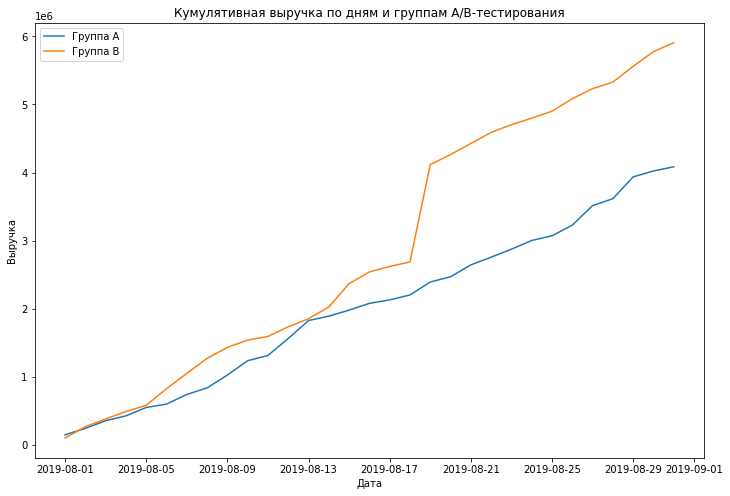

In [23]:
# зададим размеры графика 
plt.figure(figsize=(12,8))  

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

# описание графика
plt.legend(['Группа А', 'Группа B']) 
plt.xlabel('Дата')
plt.ylabel('Выручка') 
plt.title('Кумулятивная выручка по дням и группам A/B-тестирования') 
plt.show() 

Выручка растет на протяжении всего времени тестирования, однако группа В показывает лучший результат, кроме того, график имеет резкий рост 19 августа 2019 года. Это говорит, о том, что в этот день было большое количество заказов или очень дорогие заказы.

**Кумулятивный средний чек по группам.**

Для нахождения кумулятивного среднего чека необходимо разделить кумулятивную выручку на кумулятивное число заказов.

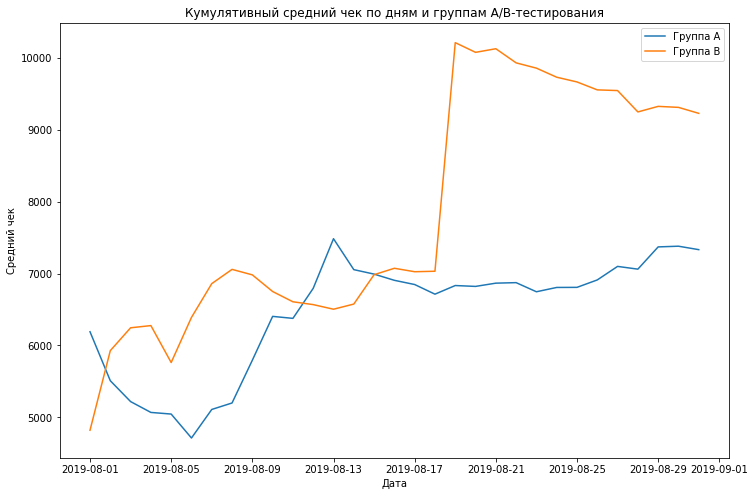

In [24]:
# зададим размеры графика 
plt.figure(figsize=(12,8)) 

# построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

# описание графика
plt.legend(['Группа А', 'Группа B']) 
plt.xlabel('Дата')
plt.ylabel('Средний чек') 
plt.title('Кумулятивный средний чек по дням и группам A/B-тестирования') 

plt.show() 

Средний чек имеет неравномерное распределение в течение половины теста, кроме того в группе В произошел резкий всплеск 19 августа 2019 года (скорее всего в группу В попали крупные заказы). Далее средний чек имеет более ровное распределение, но из-за резкого роста значений для группы В нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

**Относительное изменение кумулятивного среднего чека группы B к группе A.**

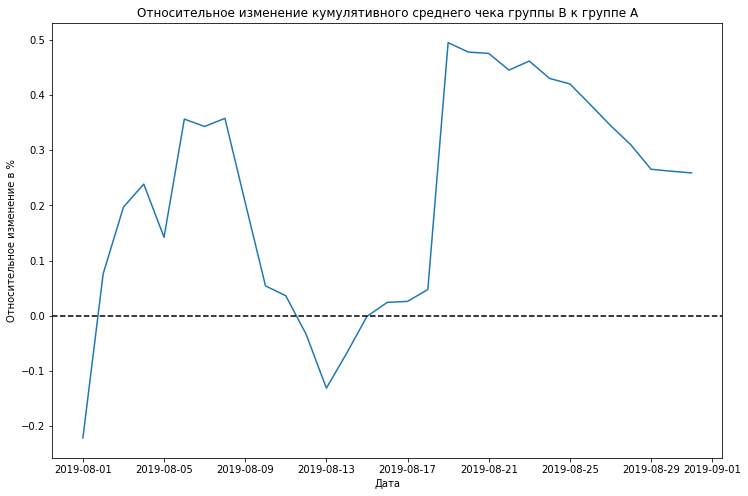

In [25]:
# зададим размеры графика 
plt.figure(figsize=(12,8)) 

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

# описание графика
plt.xlabel('Дата')
plt.ylabel('Относительное изменение в %') 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A') 

plt.show() 

В нескольких точках график различия между сегментами резко «скачет». Это свидетельствует о крупных заказах и выбросах.

**Кумулятивное среднее количество заказов на посетителя по группам.**

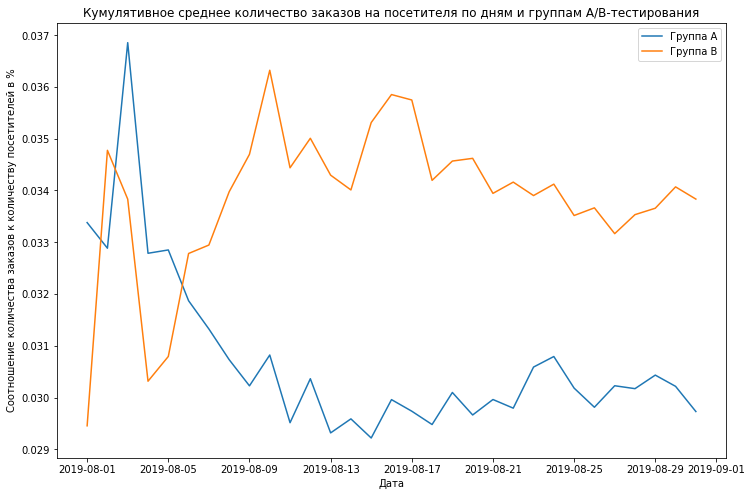

In [26]:
# зададим размеры графика 
plt.figure(figsize=(12,8)) 

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

# описание графика
plt.legend(['Группа А', 'Группа B']) 
plt.xlabel('Дата')
plt.ylabel('Соотношение количества заказов к количеству посетителей в %') 
plt.title('Кумулятивное среднее количество заказов на посетителя по дням и группам A/B-тестирования') 

plt.show() 

Обе группы имеют колебания в значениях, но к окончанию теста группы имеют более равномерные распределения. При этом группа В имеет значительно более высокие показатели. 

**Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A.**

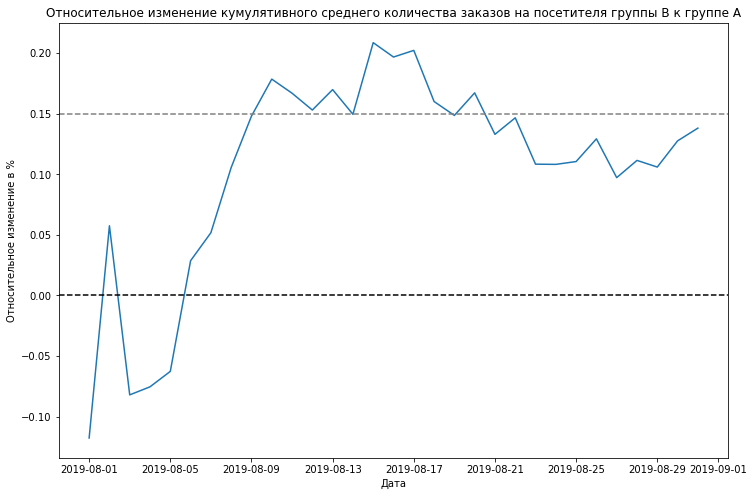

In [27]:
# зададим размеры графика 
plt.figure(figsize=(12,8)) 

# собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение среднего количества заказов
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

# добавляем ось X c нулевым приростом и отметку в 15 % 
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

# описание графика
plt.xlabel('Дата')
plt.ylabel('Относительное изменение в %') 
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A') 

plt.show() 

К середине теста относительное изменение кумулятивного среднего количества заказов на посетителя достигло более 20 %, затем этот показатель начал снижаться, но находился на уровне от 10 до 15% до конца теста.

**Точечный график количества заказов по пользователям.**

Подсчитаем количество заказов по пользователям.

In [28]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['user_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

         user_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


На основе полученной таблицы построим точечную диаграмму:

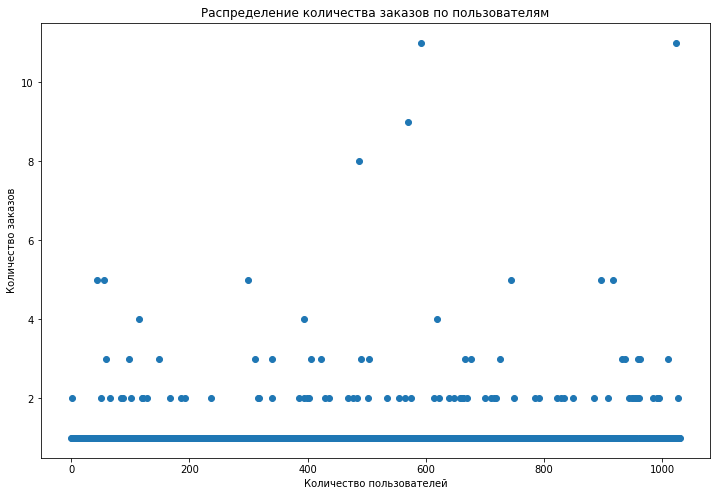

In [29]:
# зададим размеры графика 
plt.figure(figsize=(12,8)) 

# серия из чисел от 0 до количества наблюдений в ordersByUsers 
x_values = pd.Series(range(0,len(ordersByUsers)))

# построим график 
plt.scatter(x_values, ordersByUsers['orders']) 

# описание графика
plt.ylabel('Количество заказов') 
plt.xlabel('Количество пользователей') 
plt.title('Распределение количества заказов по пользователям') 
plt.show() 

В основном пользователи делают один заказ. Два заказа также нередкий случай. Есть пользователи, которые совершают от 3 до 5 заказов. Но их точная доля не ясна — непонятно, считать их аномалиями или нет. 

**Подсчёт 95-й и 99-й перцентили количества заказов на пользователя.**

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [30]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. И только 1% пользователей заказывали больше 4-х раз. Разумно выбрать 3 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

**Точечный график стоимостей заказов.**

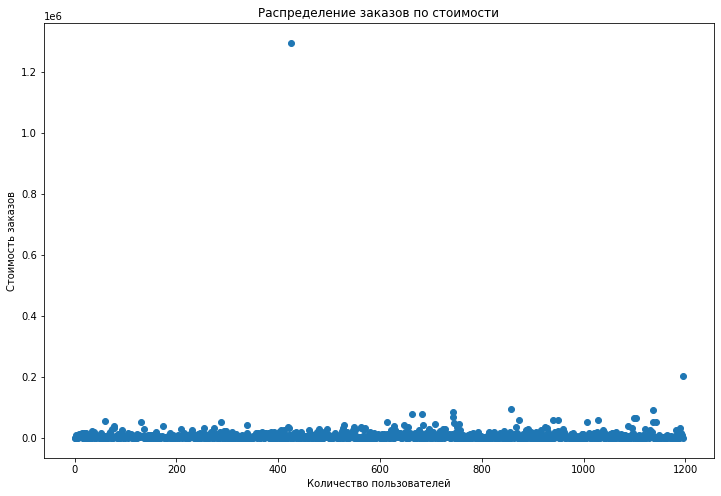

In [31]:
# зададим размеры графика 
plt.figure(figsize=(12,8)) 

# серия из чисел от 0 до количества наблюдений в orders 
x_values = pd.Series(range(0,len(orders['revenue'])))

# построим график 
plt.scatter(x_values, orders['revenue']) 

# описание графика
plt.ylabel('Стоимость заказов') 
plt.xlabel('Количество пользователей') 
plt.title('Распределение заказов по стоимости') 
plt.show() 

В данных есть аномально высокие значения в 200 тысяч и даже более 1.200.000.

**Подсчёт 95-й и 99-й перцентили стоимости заказов.**

Посчитаем выборочные перцентили стоимости заказов:

In [32]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов имеют стоимость более 28000, не более 1% заказов имеют стоимость более 58233. Выберем 28000 за верхнюю границу стоимости заказов.

**Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

Подготовим данные и посчитаем p-value, а также выведем относительный прирост среднего числа заказов группы B.

In [33]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

print("P-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост среднего количества заказов группы B к группе A: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

P-value меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13.8%.

**Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.** 

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Найдём относительные различия в среднем чеке между группами.

In [34]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительная разница среднего чека группы В к группе А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.729
Относительная разница среднего чека группы В к группе А: 0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B выше среднего чека группы A на 25%.

**Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

Ранее мы нашли 95-й и 99-й перцентили средних чеков, которые равны 28000 и 58233.2 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя, которые равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

In [35]:
# собираем пользователей с большим кол-вом заказов 
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

# собираем пользователей с слишком дорогими заказами
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
74


Всего 74 аномальных пользователя. 

Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [36]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [37]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего количества заказов группы B к группе A: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value: 0.013
Относительный прирост среднего количества заказов группы B к группе A: 0.173


P-value меньше 0.05, потому нулевую гипотезу отвергаем. Сегмент B значительно лучше сегмента A.

**Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

In [38]:
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительная разница среднего чека группы В к группе А: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.738
Относительная разница среднего чека группы В к группе А: -0.020


Как и в случае с сырыми данными, P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу нет. Но разница между сегментами сократилась с 25% до практически нулевой, средний чек в группе B даже стал ниже чем в группе A.

## Общий вывод

По результатам А/В-теста можно сделать следующие выводы:

- Есть статистически значимые различия по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A;

- График различия среднего чека говорит о том, что результаты группы B лучше группы А, но при исключении аномальных значений анамалий средний чек практически не меняется. 

Исходя из вышеизложенного, тест следует остановить и признать его успешным.